# Regularization
> 정규화, 규제

보스턴 주택 가격 예측하기

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
np.set_printoptions(suppress=True, precision=3)

<br>

### 그래프 함수 정의

In [50]:
sns.set_palette('PuRd')
colors = sns.color_palette('PuRd')

# 산점도 그리는 함수

def predict_plot(title, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})

    # 인덱스를 재배열해주지 않으면 들쭉날쭉한 형태의 기본 산점도가 그려진다
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(11, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color=colors[3])
    plt.scatter(df.index, df['actual'], marker='o', alpha=0.6, s=15, color='black')
    plt.title(title, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

In [51]:
# MSE 구하고 시각화하는 함수 (모델이 하나일 때)

mse_dict = {}

def get_mse(title, pred, actual):
    global mse_dict

    mse = mean_squared_error(pred, actual)
    mse_dict[title] = mse

    mse_list = sorted(mse_dict.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(mse_list, columns=['model', 'mse'])
    print(df)
    min_value = df['mse'].min() - 10
    max_value = df['mse'].max() + 10
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['mse'], height=0.3)
    
    for i, v in enumerate(df['mse']):
      bars[i].set_color(colors[i%len(colors)])
      ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('MSE', fontsize=16)
    plt.xlim(min_value, max_value)
    
    plt.show()

In [52]:
# MSE 시각화에 모델을 추가하거나 제거하는 함수

def add_model(title, pred, actual):
    global mse_dict
    mse = mean_squared_error(pred, actual)
    mse_dict[title] = mse


def remove_model(title):
    global mse_dict
    try:
        del mse_dict[title]
    except KeyError:
        return False
    return True

In [53]:
# MSE 구하고 시각화하는 함수 (모델이 여러 개일 때)

def get_mse_all():
    global mse_dict
    
    mse_list = sorted(mse_dict.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(mse_list, columns=['model', 'mse'])
    print(df)
    min_value = df['mse'].min() - 10
    max_value = df['mse'].max() + 10

    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['mse'], height=0.3)
    
    for i, v in enumerate(df['mse']):
      bars[i].set_color(colors[i%len(colors)])
      ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('MSE', fontsize=16)
    plt.xlim(min_value, max_value)
    
    plt.show()

<br>
<br>

## 1. 회귀 분석

### 1-1. 데이터 전처리

In [54]:
data = load_boston()

In [55]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])

In [56]:
df['target'] = data['target']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


* **CRIM**: 범죄율
* **ZN**: 25,000 평방 피트 당 주거용 토지의 비율
* **INDUS**: 비소매(non-retail) 비즈니스 면적 비율
* **CHAS**: 찰스 강 더미 변수 (통로가 하천을 향하면 1; 그렇지 않으면 0)
* **NOX**: 산화 질소 농도 (천만 분의 1)
* **RM**:주거 당 평균 객실 수
* **AGE**: 1940 년 이전에 건축된 자가 소유 점유 비율
* **DIS**: 5 개의 보스턴 고용 센터까지의 가중 거리     
* **RAD**: 고속도로 접근성 지수
* **TAX**: 10,000 달러 당 전체 가치 재산 세율
* **PTRATIO**  도시 별 학생-교사 비율
* **B**: 1000 (Bk-0.63) ^ 2 여기서 Bk는 도시 별 검정 비율입니다.
* **LSTAT**: 인구의 낮은 지위
* **target**: 자가 주택의 중앙값 (1,000 달러 단위)

<br>

### 1-2. 데이터 분할

train data와 test data로 분할한다

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), df['target'], random_state=30)
X_train.shape, X_test.shape

((379, 13), (127, 13))

In [58]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
142,3.32105,0.0,19.58,1.0,0.871,5.403,100.0,1.3216,5.0,403.0,14.7,396.90,26.82
10,0.22489,12.5,7.87,0.0,0.524,6.377,94.3,6.3467,5.0,311.0,15.2,392.52,20.45
393,8.64476,0.0,18.10,0.0,0.693,6.193,92.6,1.7912,24.0,666.0,20.2,396.90,15.17
162,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92
363,4.22239,0.0,18.10,1.0,0.770,5.803,89.0,1.9047,24.0,666.0,20.2,353.04,14.64


<br>

### 1-3. 회귀 모델 적합

In [59]:
# n_jobs: CPU코어의 사용
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

<br>

### 1-4. 예측

In [60]:
y_pred = model.predict(X_test)

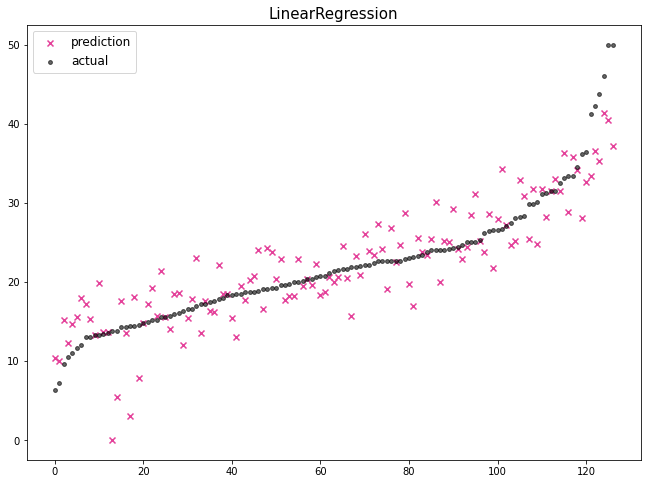

In [61]:
predict_plot('LinearRegression', y_pred, y_test)

              model        mse
0  LinearRegression  16.485165


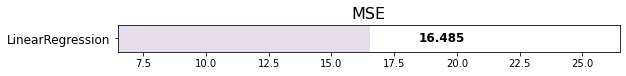

In [62]:
get_mse('LinearRegression', y_pred, y_test)

<br>
<br>

## 2. 규제 (Regularization)

### 2-1. Ridge (L2 Regularization)

In [63]:
from sklearn.linear_model import Ridge

규제 계수(alpha)를 정의한다. 값이 커질수록 큰 규제!

In [64]:
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

                 model        mse
0     Ridge(alpha=100)  18.018382
1      Ridge(alpha=10)  17.068408
2       Ridge(alpha=1)  16.652412
3     LinearRegression  16.485165
4  Ridge(alpha=0.0001)  16.485151
5   Ridge(alpha=0.001)  16.485020
6    Ridge(alpha=0.01)  16.483801
7     Ridge(alpha=0.1)  16.479483


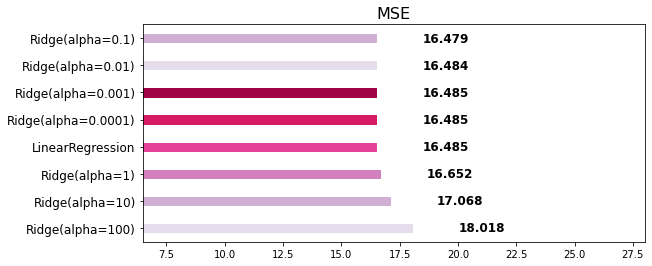

In [65]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=30)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    add_model('Ridge(alpha={})'.format(alpha), y_pred, y_test)
get_mse_all()

**feature들의 중요도 확인**

coef_는 feature의 가중치(weight): 회귀 예측시 어떤 feature가 주요하게 영향을 미쳤는지 보여준다.

In [66]:
ridge.coef_

array([ -0.115,   0.04 ,  -0.003,   3.487, -18.012,   3.729,   0.005,
        -1.529,   0.325,  -0.013,  -0.957,   0.006,  -0.557])

In [67]:
pd.DataFrame(list(zip(X_train.columns, ridge.coef_)), columns=['features', 'importances']).sort_values('importances')

,features,importances
4,NOX,-18.012494
7,DIS,-1.529399
10,PTRATIO,-0.957246
12,LSTAT,-0.557350
0,CRIM,-0.114736
9,TAX,-0.013134
2,INDUS,-0.002879
6,AGE,0.004546
11,B,0.006369
1,ZN,0.040452


In [101]:
def plot_coef(title, columns, coef, alpha):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns = ['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'], color=colors[3])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.title('{}(alpha={})' .format(title, alpha))
    plt.show()

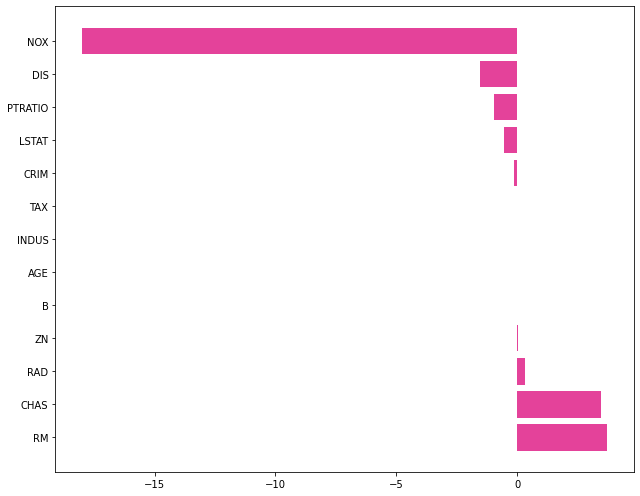

Text(0.5, 1.0, 'Ridge(alpha=0.0001)')

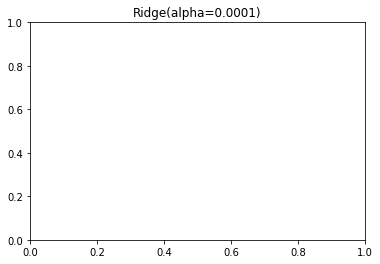

In [100]:
plot_coef('Ridge', X_train.columns, ridge.coef_, 0.0001)

<br>

**alpha 값에 따른 coef 의 차이**

In [71]:
ridge_100 = Ridge(alpha=100)
ridge_100.fit(X_train, y_train)
ridge_pred_100 = ridge_100.predict(X_test)

ridge_001 = Ridge(alpha=0.001)
ridge_001.fit(X_train, y_train)
ridge_pred_001 = ridge_001.predict(X_test)

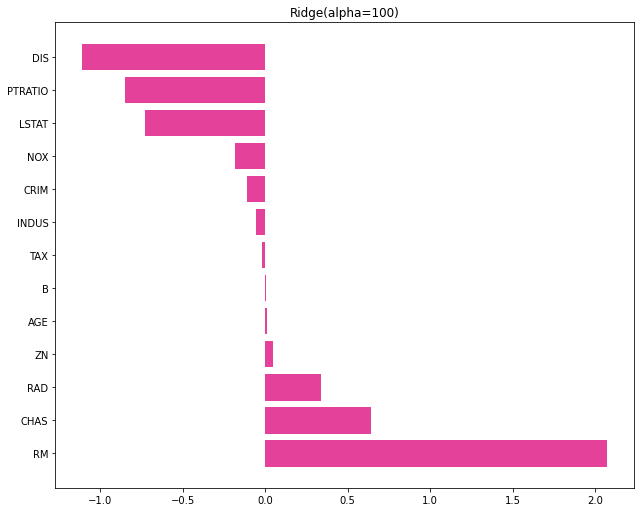

In [81]:
plot_coef('Ridge', X_train.columns, ridge_100.coef_, 100)

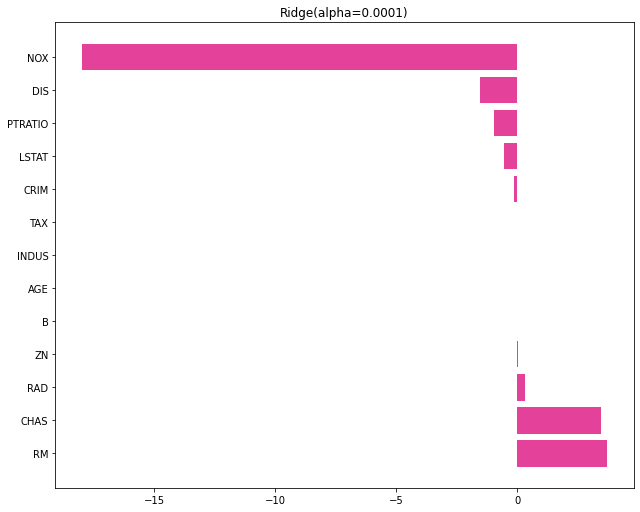

In [82]:
plot_coef('Ridge', X_train.columns, ridge_001.coef_, 0.0001)

<br>
<br>

## 2-2. Lasso (L1 Regularization)

In [83]:
from sklearn.linear_model import Lasso

In [84]:
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

                  model        mse
0      Lasso(alpha=100)  48.725206
1       Lasso(alpha=10)  27.146245
2        Lasso(alpha=1)  19.882302
3      Ridge(alpha=100)  18.018382
4      Lasso(alpha=0.1)  17.083615
5       Ridge(alpha=10)  17.068408
6        Ridge(alpha=1)  16.652412
7      LinearRegression  16.485165
8   Ridge(alpha=0.0001)  16.485151
9    Ridge(alpha=0.001)  16.485020
10  Lasso(alpha=0.0001)  16.484261
11    Ridge(alpha=0.01)  16.483801
12     Ridge(alpha=0.1)  16.479483
13   Lasso(alpha=0.001)  16.476551
14    Lasso(alpha=0.01)  16.441822


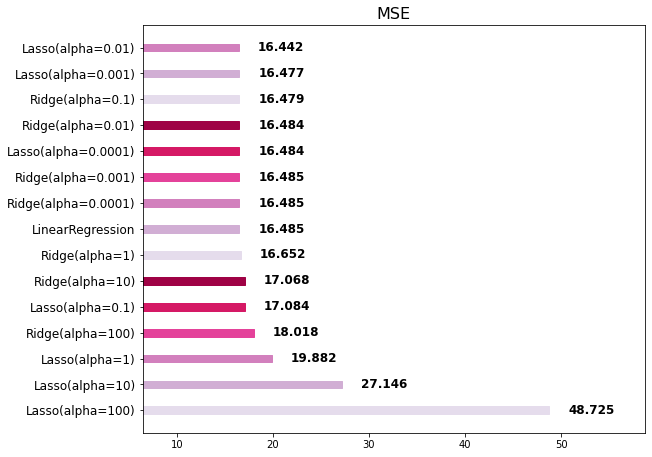

In [85]:
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_test)
    add_model('Lasso(alpha={})'.format(alpha), pred, y_test)
get_mse_all()

In [87]:
lasso_100 = Lasso(alpha=100)
lasso_100.fit(X_train, y_train)
lasso_pred_100 = lasso_100.predict(X_test)

lasso_001 = Lasso(alpha=0.001)
lasso_001.fit(X_train, y_train)
lasso_pred_001 = lasso_001.predict(X_test)

Lasso 모델에서는 너무 큰 alpha 계수를 적용하면 대부분의 feature들의 가중치가 0으로 수렴한다.

In [202]:
lasso_100.coef_

array([-0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,
        0.   , -0.022, -0.   ,  0.004, -0.   ])

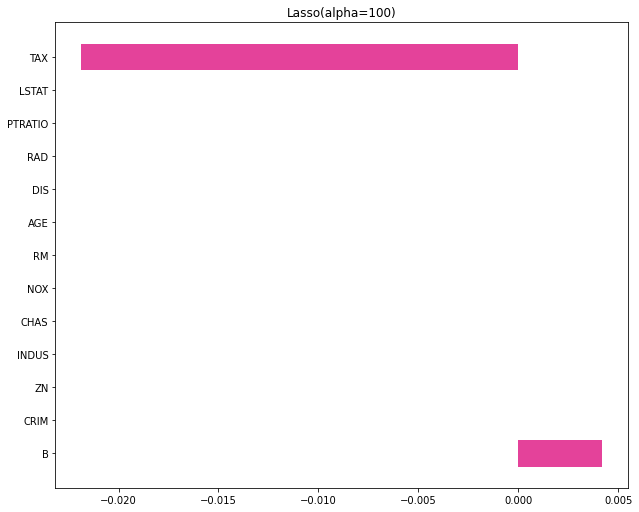

In [88]:
plot_coef('Lasso', X_train.columns, lasso_100.coef_, 100)

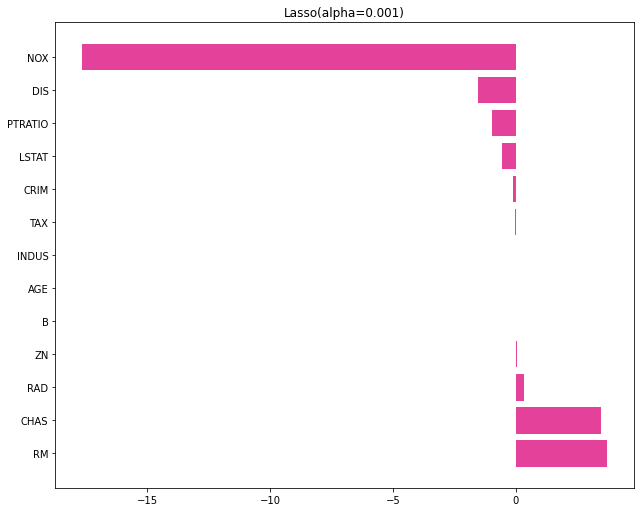

In [90]:
plot_coef('Lasso', X_train.columns, lasso_001.coef_, 0.001)

<br>
<br>

### 2-3. ElasticNet

In [91]:
from sklearn.linear_model import ElasticNet

In [92]:
alpha = 0.01
ratios = [0.2, 0.5, 0.8]

                       model        mse
0           Lasso(alpha=100)  48.725206
1            Lasso(alpha=10)  27.146245
2             Lasso(alpha=1)  19.882302
3           Ridge(alpha=100)  18.018382
4           Lasso(alpha=0.1)  17.083615
5            Ridge(alpha=10)  17.068408
6   ElasticNet(l1_ratio=0.2)  16.914638
7   ElasticNet(l1_ratio=0.5)  16.822431
8             Ridge(alpha=1)  16.652412
9   ElasticNet(l1_ratio=0.8)  16.638817
10          LinearRegression  16.485165
11       Ridge(alpha=0.0001)  16.485151
12        Ridge(alpha=0.001)  16.485020
13       Lasso(alpha=0.0001)  16.484261
14         Ridge(alpha=0.01)  16.483801
15          Ridge(alpha=0.1)  16.479483
16        Lasso(alpha=0.001)  16.476551
17         Lasso(alpha=0.01)  16.441822


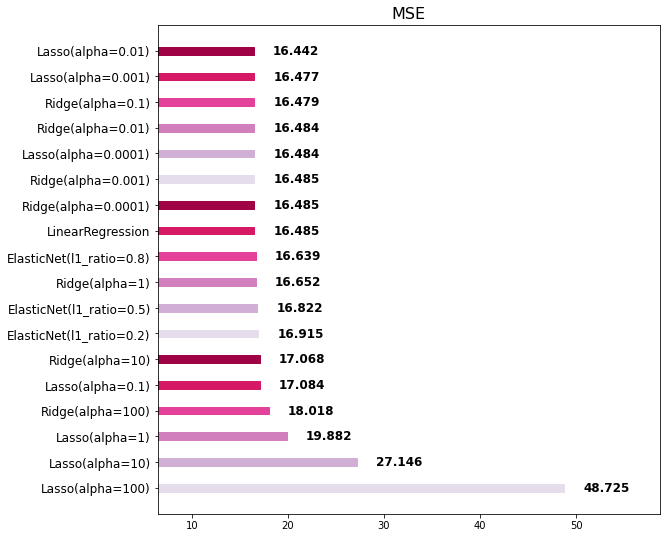

In [94]:
for ratio in ratios:
    elasticnet = ElasticNet(alpha=alpha, l1_ratio=ratio, random_state=30)
    elasticnet.fit(X_train, y_train)
    pred = elasticnet.predict(X_test)
    add_model('ElasticNet(l1_ratio={})'.format(ratio), pred, y_test)
get_mse_all()

In [102]:
def plot_coef2(title, columns, coef, ratio):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns = ['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'], color=colors[3])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.title('{}(l1_ratio={})' .format(title, ratio))
    plt.show()

In [103]:
elsticnet_20 = ElasticNet(alpha=5, l1_ratio=0.2)
elsticnet_20.fit(X_train, y_train)
elasticnet_pred_20 = elsticnet_20.predict(X_test)

elsticnet_80 = ElasticNet(alpha=5, l1_ratio=0.8)
elsticnet_80.fit(X_train, y_train)
elasticnet_pred_80 = elsticnet_80.predict(X_test)

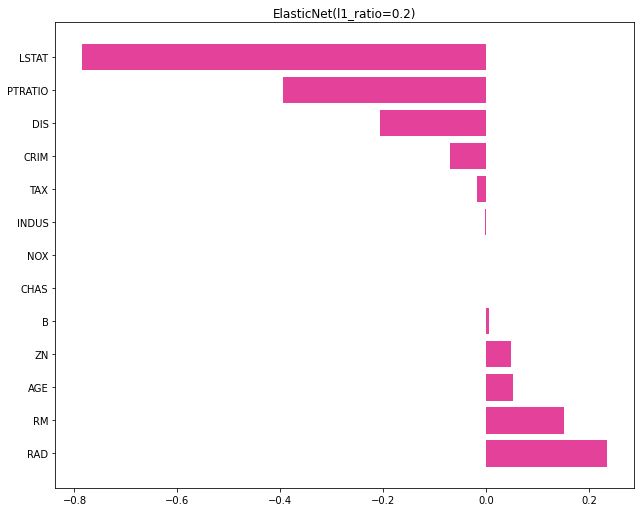

In [105]:
plot_coef2('ElasticNet', X_train.columns, elsticnet_20.coef_, 0.2)

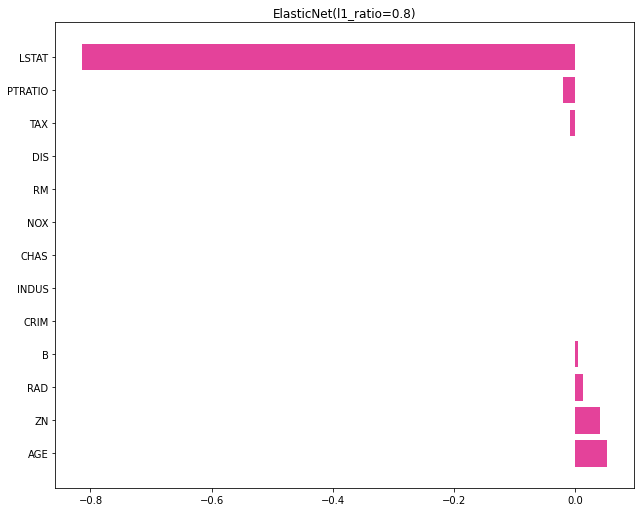

In [106]:
plot_coef2('ElasticNet', X_train.columns, elsticnet_80.coef_, 0.8)

<br>
<br>

---
[참고 자료](https://teddylee777.github.io/scikit-learn/scikit-learn-linear-with-regularizations)